# 05-Valid/Test set, Overfitting & Underfitting, Regularization

[1.Train/Valid/Test dataset](#1)

[2.Define Model & Training](#2)
  - [2-1.Forward Propagation](#2-1)
  - [2-2.Compute Loss](#2-2)
  - [2-3.Back Propagation](#2-3)
  - [2-4.Update Parameters](#2-4)
  - [2-5.weight initialization](#2-5)
  - [2-6.training](#2-6)

[3.Weight Regularization](#3)

[4.Dropout](#4)

[5.Trainig](#5)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

<a id="1"></a>
## 1.Train/Valid/Test dataset

In [2]:
# 데이터셋 생성
X, Y = make_moons(n_samples=6000, noise=0.45, random_state=42)

# 데이터를 학습 및 테스트 세트로 분할
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.1, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Y 레이블을 (n, 1) 형태로 변환
train_y = train_y.reshape(-1, 1)
valid_y = valid_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

# 넘파이 배열로 변환
train_x = train_x.T
train_y = train_y.T
valid_x = valid_x.T
valid_y = valid_y.T
test_x = test_x.T
test_y = test_y.T

# 데이터 형태 확인
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)

print("valid_x shape:", valid_x.shape)
print("valid_y shape:", valid_y.shape)

print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)

train_x shape: (2, 4320)
train_y shape: (1, 4320)
valid_x shape: (2, 1080)
valid_y shape: (1, 1080)
test_x shape: (2, 600)
test_y shape: (1, 600)


In [3]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []

    ## Shuffle
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))

    num_mini_batches = math.floor(m / mini_batch_size)
    for k in range(0, num_mini_batches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    ## 마지막 미니배치의 크기가 batch_size와 다른 경우. 나머지 데이터들을 묶어서 미니 배치를 생성.
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_mini_batches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_mini_batches * mini_batch_size:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

<a id="2"></a>
## 2.Define Model & Training

<a id="2-1"></a>
### 2-1. Forward Propagation

In [4]:
def forward_propagation(X, parameters):
    """
    Arguments:
     - X : input data (n_x, m) n_x는 feature 수, m은 데이터 샘플 수
     - parameters : 각 layer의 trainable params dict타입 {"W1", "b1", ..., "WL", "bL"}

    Returns:
     - AL : 출력층(L번째 layer)의 activation feature
     - caches : 각 층의 (input, weight, bias, output)
    """
    caches = []
    A = X
    L = len(parameters) // 2
    
    # [LINEAR -> RELU]*(L-1)
    for l in range(1, L):
        A_prev = A 
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        Z = np.dot(W, A_prev) + b
        A = np.maximum(0, Z)  # ReLU
        cache = (A_prev, W, b, Z)
        caches.append(cache)
        
    # LINEAR -> SIGMOID
    WL = parameters['W' + str(L)]
    bL = parameters['b' + str(L)]
    ZL = np.dot(WL, A) + bL
    AL = 1 / (1 + np.exp(-ZL))  # Sigmoid
    cache = (A, WL, bL, ZL)
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches

<a id="2-2"></a>
### 2-2. compute_loss

In [5]:
def compute_cost(AL, Y):
    """
    Arguments:
     - AL : label 예측에 해당하는 확률 벡터. (1, num of data samples)
     - Y : ground-truth 벡터. (1, num of data samples)

    Returns:
     - cost : cross-entropy cost
    """
    m = Y.shape[1]

    # logprobs = np.multiply(np.log(AL), Y) + np.multiply((1 - Y), np.log(1 - AL))
    logprobs = np.multiply(np.log(AL + 1e-10), Y) + np.multiply((1 - Y), np.log(1 - AL + 1e-10))

    cost = -np.sum(logprobs) / m

    cost = float(np.squeeze(cost))

    return cost

<a id="2-3"></a>
### 2-3.Back Propagation

In [6]:
def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0

    return dZ

def sigmoid_backward(dA, Z):
    S = 1 / (1 + np.exp(-Z))
    dZ = dA * S * (1-S)

    return dZ

def backward_propagation(X, Y, caches, AL):
    """
    Backward Propagation.
    L-1개의 [Linear -> ReLU] layer와 출력층 [Linear -> Sigmoid]의 parameter에 대한 gradient를 계산한다.

    Arguments:
     - X : 입력 데이터. (n_x, m) n_x는 feature 수, m은 데이터 샘플의 수
     - Y : ground_truth. (1, m)
     - caches : list 타입. 각 layer의 (input, weight, bias, output).
     - AL : 마지막 출력층의 출력값. y hat.
    """
    grads = {}
    L = len(caches) ## layer 수
    m = X.shape[1] ## 데이터 샘플의 수

    ## cost function gradient
    # dAL = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    dAL = -(np.divide(Y, AL + 1e-10) - np.divide(1 - Y, 1 - AL + 1e-10))

    ## L번째 layer(출력층) [sigmoid -> Linear] gradient
    cache = caches[-1]
    A_prev, WL, bL, ZL = cache
    dZL = sigmoid_backward(dAL, ZL) ## dL/dA * dA/dZ = dL / dZ
    dWL = np.dot(dZL, A_prev.T) ## dL/dZ * dZ/dW = dL/dW
    dbL = np.sum(dZL, axis=1, keepdims=True) / m ## dL/dZ * dZ/db = dL/db
    dA_prev = np.dot(WL.T, dZL) ## dL/dZ * dZ/dX = dL/dX

    grads["dA" + str(L)] = dA_prev
    grads["dW" + str(L)] = dWL
    grads["db" + str(L)] = dbL

    for l in reversed(range(L-1)):
        cache = caches[l]
        A_prev, W, b, Z = cache
        dZ = relu_backward(grads["dA" + str(l + 2)], Z)
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        dA_prev = np.dot(W.T, dZ)

        grads["dA" + str(l + 1)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db
    
    return grads

<a id="2-4"></a>
### 2-4.Update Parameters

In [7]:
def update_parameters_with_gradient_descent(parameters, grads, learning_rate):
    """
    Gradient Descent 방식으로 parameter를 업데이트.

    Arguments:
     - parameters : dict 타입. layer에 설정된 weight, bias
     - grads : dict 타입. 각 parameter에 대한 gradients
     - learning rate : 실수형. 

    Returns:
     - parameters : dict 타입. gradient로 업데이트된 parameters
    """
    L = len(parameters) // 2 ## nn을 구성하는 layer 수

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads['dW' + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads['db' + str(l)]

    return parameters

<a id="2-5"></a>
### 2-5.weight initialization

In [8]:
def initialize_parameters_random(layers_dims):
    """
    Normal Distribution을 기반으로 랜덤값을 선정.

    Arguments:
     - layer_dims : 각 layer에 설정할 unit의 수. list 타입
    
    Returns:
     - parameters : 각 layer에 설정되는 weight(matrix, "W1", "W2",..."WL"), bias(vector, "b1", "b2",..."bL")의 dictionary 타입
                    W1 : weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 : bias vector of shape (layers_dims[1], 1)
                    ...
                    WL : weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL : bias vector of shape (layers_dims[L], 1)
    """
    np.random.seed(3)

    parameters = {}
    L = len(layers_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 10
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters


def initialize_parameters_xavier(layers_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1
    
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(1 / layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
                
    return parameters


def initialize_parameters_he(layers_dims):  
    ## He Normal Distribution을 따라 확률 변수들에 확률을 부여하고, 랜덤으로 가중치 값을 선정.
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
                
    return parameters

<a id="2-6"></a>
### 2-6. training

In [25]:
def model(X, Y, learning_rate=0.001, num_iterations=30000, print_cost=True):       
    grads = {}
    costs = []
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    parameters = initialize_parameters_he(layers_dims)

    for i in range(0, num_iterations):
        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        a3, cache = forward_propagation(X, parameters)
        
        # Cost function
        cost = compute_cost(a3, Y)
            
        # Backward propagation.
        grads = backward_propagation(X, Y, cache, a3)
        
        # Update parameters.
        parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 1.9933752227025026
Cost after iteration 10000: 0.35806314867460776
Cost after iteration 20000: 0.35479040231341497


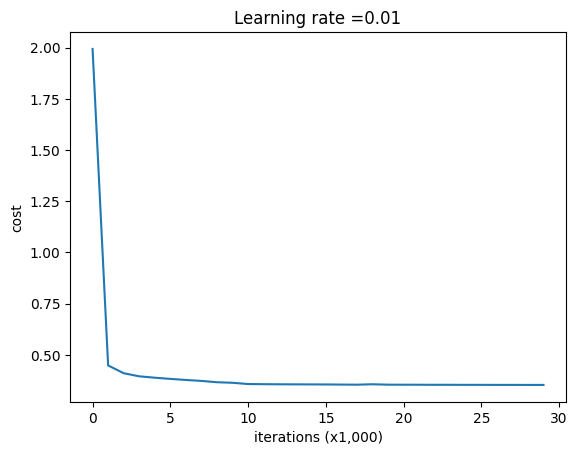

In [26]:
parameters = model(train_x, train_y, learning_rate=0.01)

<a id="3"></a>
## 3.Weight Regularization

In [11]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    L2 Regularization을 적용한 cost function.
    Arguments:
     - A3 : L번째 layer(출력층)의 출력값 (output size, number of examples)
     - Y : ground-truth (output size, number of examples)
     - parameters : 각 층에 적용된 trainable parameters
    
    Returns:
     - cost : L2 정규화가 더해진 cost값.
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y)
    L2_regularization_cost = (lambd / (2 * m)) * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [12]:
def backward_propagation_with_regularization(X, Y, caches, lambd):
    """
    L2 regularization이 적용되었을 때의 Back propagation

    Arguments:
    - X : input dataset. (input features, number of examples)
    - Y : ground-truth. (output size, number of examples)
    - caches : forward propagation에서 각 layer의 (A_prev, W, b, Z)가 저장된 리스트
    - lambd : regularization의 scaling factor

    Returns:
    - grads : 각 layer에서 발생한 gradient.
    """
    grads = {}
    L = len(caches)  # the number of layers
    m = X.shape[1]
    Y = Y.reshape(caches[-1][3].shape)  # after this line, Y is the same shape as AL

    # Initializing the backpropagation
    AL, current_cache = caches[-1][2], caches[-1]
    dZL = AL - Y  # Derivative of cost with respect to AL
    dWL = 1./m * np.dot(dZL, current_cache[0].T) + (lambd/m) * current_cache[1]
    dbL = 1./m * np.sum(dZL, axis=1, keepdims=True)
    dAL_prev = np.dot(current_cache[1].T, dZL)
    
    grads["dW" + str(L)] = dWL
    grads["db" + str(L)] = dbL

    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dZ = np.multiply(dAL_prev, current_cache[3])
        dW = 1./m * np.dot(dZ, current_cache[0].T) + (lambd/m) * current_cache[1]
        db = 1./m * np.sum(dZ, axis=1, keepdims=True)
        if l > 0:  # dA_prev is not used for the first layer
            dAL_prev = np.dot(current_cache[1].T, dZ)

        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db

    return grads


<a id="4"></a>
## 4.Dropout

In [13]:
def forward_propagation_with_dropout(X, parameters, keep_prob=0.5):
    """
    LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
     - X : input dataset. (num features, number of examples)
     - parameters : 각 layer에 적용되는 trainable parameters.
                    W1 : weight matrix of shape (20, 2)
                    b1 : bias vector of shape (20, 1)
                    W2 : weight matrix of shape (3, 20)
                    b2 : bias vector of shape (3, 1)
                    W3 : weight matrix of shape (1, 3)
                    b3 : bias vector of shape (1, 1)
     - keep_prob : dropout이 적용되지 않는, 활성화되는 unit의 수(백분율)
    
    Returns:
     - A3 : output layer의 출력.
     - cache : 각 layer의 (input, weight, bias, output)
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = np.maximum(0, Z1) ## ReLU

    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    D1 = (D1 < keep_prob).astype(int)
    A1 = np.multiply(D1, A1)
    A1 /= keep_prob
    
    Z2 = np.dot(W2, A1) + b2
    A2 = np.maximum(0, Z2) ## ReLU

    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = (D2 < keep_prob).astype(int)
    A2 = np.multiply(D2, A2)
    A2 /= keep_prob
    
    
    Z3 = np.dot(W3, A2) + b3
    A3 = 1 / (1 + np.exp(-Z3)) ## Sigmoid    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [14]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Dropout이 적용되었을 때의 Backward propagation.
    
    Arguments:
     - X : input dataset. (num features, number of examples)
     - Y : ground-truth. (output size, number of examples)
     - cache : forward propagation에서 각 layer의 (input, weight, bias, output)
     - keep_prob : keep_prob : dropout이 적용되지 않는, 활성화되는 unit의 수(백분율)
    
    Returns:
     - gradients : 각 layer에서 발생한 gradient.
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)

    dA2 *= D2
    dA2 /= keep_prob
        
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 *= D1
    dA1 /= keep_prob
    
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

<a id="5"></a>
## 5.Training

In [15]:
def model(X, Y, learning_rate=0.001, num_iterations=100000, print_cost=True, lambd=0, keep_prob=1):       
    grads = {}
    costs = []
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 4, 2, 1]
    
    parameters = initialize_parameters_he(layers_dims)

    for i in range(0, num_iterations):
        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        assert (lambd == 0 or keep_prob == 1)
        # Backward propagation.
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters_with_gradient_descent(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 1.7471728477045472


Cost after iteration 10000: 1.1677491152153545
Cost after iteration 20000: 0.9817028593707734
Cost after iteration 30000: 0.8937694914687898
Cost after iteration 40000: 0.843862447700454
Cost after iteration 50000: 0.8118798353128428
Cost after iteration 60000: 0.7900997592563318
Cost after iteration 70000: 0.7748737080905029
Cost after iteration 80000: 0.7641984133383106
Cost after iteration 90000: 0.7566895283663235


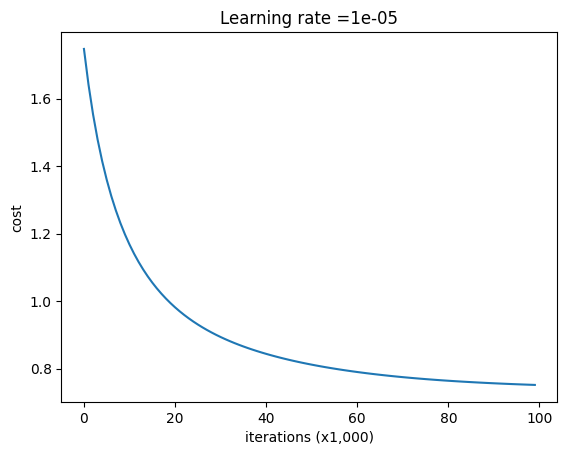

In [22]:
parameters = model(train_x, train_y, learning_rate=0.00001, lambd=0.7)

Cost after iteration 0: 1.8165254733786733
Cost after iteration 10000: 1.4680594853517868
Cost after iteration 20000: 1.2293373542370418
Cost after iteration 30000: 1.0668793666937972
Cost after iteration 40000: 0.9574814820441842
Cost after iteration 50000: 0.8839042985550835
Cost after iteration 60000: 0.8339668107689485
Cost after iteration 70000: 0.7974033137121852
Cost after iteration 80000: 0.7742982158004564
Cost after iteration 90000: 0.7622580996492309


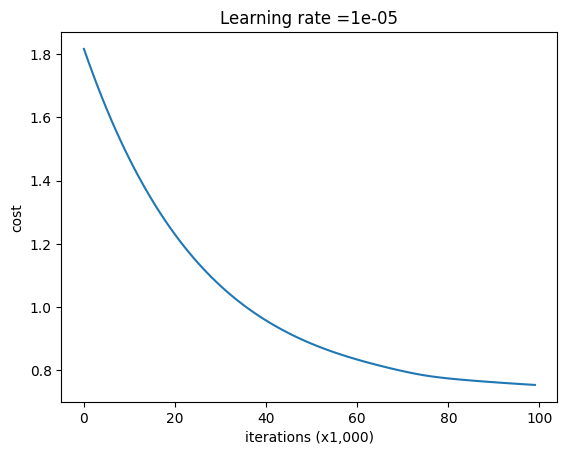

In [23]:
parameters = model(train_x, train_y, learning_rate=0.00001, keep_prob=0.8)